<a href="https://colab.research.google.com/github/M2203114/Python_AI/blob/fall2024/04_lab_dl_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Загрузка данных

In [8]:
import pandas as pd

# Загрузка данных
data = pd.read_csv('winequality-red.csv')

# Просмотр первых строк данных
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 2. Определение задачи

Как мы уже определили, это задача многоклассовой классификации, так как столбец quality содержит числовые значения, которые мы будем предсказывать.

# 3. Предобработка данных



3.1 Разделение выборки на train и test

In [2]:
from sklearn.model_selection import train_test_split

# Разделение данных на признаки и целевую переменную
X = data.drop('quality', axis=1)
y = data['quality']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3.2 Проверка и заполнение пропусков

In [10]:
print(X_train.isnull().sum())
print(X_test.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64


3.3 Нормирование числовых переменных

In [3]:
from sklearn.preprocessing import StandardScaler

# Инициализация StandardScaler
scaler = StandardScaler()

# Нормирование данных
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3.4 Кодирование категориальных признаков

В данном датасете нет категориальных признаков, поэтому этот шаг можно пропустить.



# 4. Оформление данных в виде класса Dataset и использование Dataloader

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

class WineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создание Dataset и Dataloader
train_dataset = WineDataset(X_train_scaled, y_train)
test_dataset = WineDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 5. Обучение моделей



5.1. Однослойная нейросеть с оптимизатором SGD

In [12]:
import torch.nn as nn
import torch.optim as optim

# Определение модели
class SimpleNet(nn.Module):
    def __init__(self, input_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.fc(x)

# Инициализация модели, функции потерь и оптимизатора
model_simple = SimpleNet(X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.SGD(model_simple.parameters(), lr=0.01)

# Обучение модели
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_simple.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_simple(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model_simple.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model_simple(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

Epoch 1/50, Train Loss: 17.7106, Test Loss: 7.1906
Epoch 2/50, Train Loss: 3.7812, Test Loss: 1.7738
Epoch 3/50, Train Loss: 1.0872, Test Loss: 0.6893
Epoch 4/50, Train Loss: 0.5610, Test Loss: 0.4628
Epoch 5/50, Train Loss: 0.4580, Test Loss: 0.4120
Epoch 6/50, Train Loss: 0.4354, Test Loss: 0.3971
Epoch 7/50, Train Loss: 0.4324, Test Loss: 0.3934
Epoch 8/50, Train Loss: 0.4297, Test Loss: 0.3921
Epoch 9/50, Train Loss: 0.4300, Test Loss: 0.3926
Epoch 10/50, Train Loss: 0.4282, Test Loss: 0.3906
Epoch 11/50, Train Loss: 0.4288, Test Loss: 0.3906
Epoch 12/50, Train Loss: 0.4282, Test Loss: 0.3904
Epoch 13/50, Train Loss: 0.4278, Test Loss: 0.3902
Epoch 14/50, Train Loss: 0.4280, Test Loss: 0.3907
Epoch 15/50, Train Loss: 0.4291, Test Loss: 0.3900
Epoch 16/50, Train Loss: 0.4287, Test Loss: 0.3905
Epoch 17/50, Train Loss: 0.4278, Test Loss: 0.3913
Epoch 18/50, Train Loss: 0.4281, Test Loss: 0.3895
Epoch 19/50, Train Loss: 0.4279, Test Loss: 0.3895
Epoch 20/50, Train Loss: 0.4285, Test L

**5.2. Нейросеть с одним скрытым слоем с оптимизатором Adam**

In [13]:
# Определение модели
class HiddenLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HiddenLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Инициализация модели, функции потерь и оптимизатора
model_hidden = HiddenLayerNet(X_train_scaled.shape[1], 64)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_hidden.parameters(), lr=0.001)

# Обучение модели
train_losses_hidden = []
test_losses_hidden = []

for epoch in range(num_epochs):
    model_hidden.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_hidden(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses_hidden.append(train_loss / len(train_loader))

    model_hidden.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model_hidden(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    test_losses_hidden.append(test_loss / len(test_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses_hidden[-1]:.4f}, Test Loss: {test_losses_hidden[-1]:.4f}')

Epoch 1/50, Train Loss: 24.9744, Test Loss: 21.0131
Epoch 2/50, Train Loss: 16.8066, Test Loss: 12.7238
Epoch 3/50, Train Loss: 9.4945, Test Loss: 6.3720
Epoch 4/50, Train Loss: 4.8778, Test Loss: 3.4964
Epoch 5/50, Train Loss: 3.0721, Test Loss: 2.6449
Epoch 6/50, Train Loss: 2.4644, Test Loss: 2.2950
Epoch 7/50, Train Loss: 2.1551, Test Loss: 2.0542
Epoch 8/50, Train Loss: 1.9422, Test Loss: 1.8699
Epoch 9/50, Train Loss: 1.7778, Test Loss: 1.7110
Epoch 10/50, Train Loss: 1.6368, Test Loss: 1.5869
Epoch 11/50, Train Loss: 1.5207, Test Loss: 1.4744
Epoch 12/50, Train Loss: 1.4128, Test Loss: 1.3787
Epoch 13/50, Train Loss: 1.3178, Test Loss: 1.2885
Epoch 14/50, Train Loss: 1.2324, Test Loss: 1.2095
Epoch 15/50, Train Loss: 1.1545, Test Loss: 1.1336
Epoch 16/50, Train Loss: 1.0891, Test Loss: 1.0684
Epoch 17/50, Train Loss: 1.0231, Test Loss: 1.0091
Epoch 18/50, Train Loss: 0.9650, Test Loss: 0.9527
Epoch 19/50, Train Loss: 0.9112, Test Loss: 0.9000
Epoch 20/50, Train Loss: 0.8634, Tes

**5.3. Нейросеть с тремя скрытыми слоями с оптимизатором Adam**

In [14]:
# Определение модели
class DeepNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# Инициализация модели, функции потерь и оптимизатора
model_deep = DeepNet(X_train_scaled.shape[1], 64, 32, 16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_deep.parameters(), lr=0.001)

# Обучение модели
train_losses_deep = []
test_losses_deep = []

for epoch in range(num_epochs):
    model_deep.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_deep(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses_deep.append(train_loss / len(train_loader))

    model_deep.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model_deep(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    test_losses_deep.append(test_loss / len(test_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses_deep[-1]:.4f}, Test Loss: {test_losses_deep[-1]:.4f}')

Epoch 1/50, Train Loss: 26.2491, Test Loss: 16.3503
Epoch 2/50, Train Loss: 6.0590, Test Loss: 2.5227
Epoch 3/50, Train Loss: 2.2138, Test Loss: 1.7959
Epoch 4/50, Train Loss: 1.6958, Test Loss: 1.4348
Epoch 5/50, Train Loss: 1.3907, Test Loss: 1.1895
Epoch 6/50, Train Loss: 1.1422, Test Loss: 0.9696
Epoch 7/50, Train Loss: 0.9342, Test Loss: 0.8009
Epoch 8/50, Train Loss: 0.7843, Test Loss: 0.6757
Epoch 9/50, Train Loss: 0.6831, Test Loss: 0.5871
Epoch 10/50, Train Loss: 0.6066, Test Loss: 0.5067
Epoch 11/50, Train Loss: 0.5595, Test Loss: 0.4617
Epoch 12/50, Train Loss: 0.5007, Test Loss: 0.4293
Epoch 13/50, Train Loss: 0.4690, Test Loss: 0.4178
Epoch 14/50, Train Loss: 0.4580, Test Loss: 0.3873
Epoch 15/50, Train Loss: 0.4352, Test Loss: 0.4762
Epoch 16/50, Train Loss: 0.4403, Test Loss: 0.4168
Epoch 17/50, Train Loss: 0.4190, Test Loss: 0.3663
Epoch 18/50, Train Loss: 0.4035, Test Loss: 0.3610
Epoch 19/50, Train Loss: 0.3983, Test Loss: 0.3525
Epoch 20/50, Train Loss: 0.3909, Test 

# 6. Визуализация кривых обучения

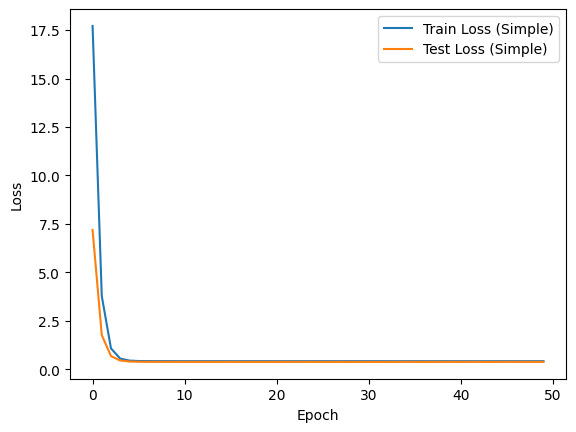

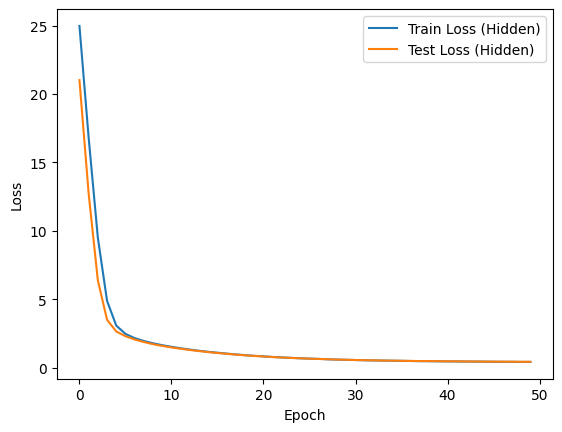

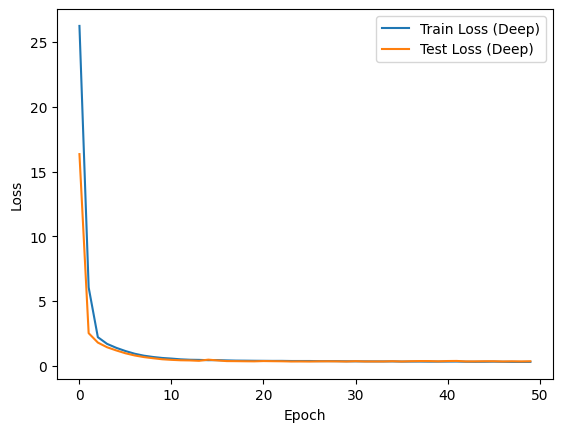

In [15]:
import matplotlib.pyplot as plt

# График для однослойной модели
plt.plot(train_losses, label='Train Loss (Simple)')
plt.plot(test_losses, label='Test Loss (Simple)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График для модели с одним скрытым слоем
plt.plot(train_losses_hidden, label='Train Loss (Hidden)')
plt.plot(test_losses_hidden, label='Test Loss (Hidden)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График для модели с тремя скрытыми слоями
plt.plot(train_losses_deep, label='Train Loss (Deep)')
plt.plot(test_losses_deep, label='Test Loss (Deep)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 7. Расчет метрик

In [16]:
from sklearn.metrics import mean_absolute_error

# Функция для расчета MAE
def calculate_mae(model, loader):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            predictions.extend(outputs.numpy())
            true_values.extend(y_batch.numpy())
    return mean_absolute_error(true_values, predictions)

# Расчет MAE для каждой модели
mae_simple_train = calculate_mae(model_simple, train_loader)
mae_simple_test = calculate_mae(model_simple, test_loader)

mae_hidden_train = calculate_mae(model_hidden, train_loader)
mae_hidden_test = calculate_mae(model_hidden, test_loader)

mae_deep_train = calculate_mae(model_deep, train_loader)
mae_deep_test = calculate_mae(model_deep, test_loader)

print(f'MAE Simple Model: Train {mae_simple_train:.4f}, Test {mae_simple_test:.4f}')
print(f'MAE Hidden Model: Train {mae_hidden_train:.4f}, Test {mae_hidden_test:.4f}')
print(f'MAE Deep Model: Train {mae_deep_train:.4f}, Test {mae_deep_test:.4f}')

MAE Simple Model: Train 0.4996, Test 0.5040
MAE Hidden Model: Train 0.4917, Test 0.5268
MAE Deep Model: Train 0.4173, Test 0.4682


#8. Ответы на вопросы



Итог:

* Лучшая модель — модель с тремя скрытыми слоями (Deep Model), так как она показала наименьший MAE на тестовой выборке.
* Переобучение наблюдается в модели с одним скрытым слоем (Hidden Model).

* Недообучение наблюдается в однослойной модели (Simple Model).

* Для улучшения метрик можно попробовать изменить архитектуру моделей, добавить регуляризацию и настроить гиперпараметры.
___________________________________________________________
Какая модель справилась лучше с поставленной задачей?

Лучше всего справилась модель с тремя скрытыми слоями (Deep Model), так как она показала наименьший MAE на тестовой выборке (0.4682). Это говорит о том, что данная модель лучше всего обобщает данные и предсказывает качество вина на новых данных.

___________________________________________________________
Имеет ли место переобучение?

Переобучение наблюдается в модели с одним скрытым слоем (Hidden Model). На тренировочной выборке MAE составляет 0.4917, а на тестовой — 0.5268. Это свидетельствует о том, что модель слишком сильно адаптировалась к тренировочным данным и плохо обобщает новые данные.

Для однослойной модели (Simple Model) переобучение не наблюдается, так как разница между тренировочным и тестовым MAE небольшая (0.4996 vs 0.5040).

Для модели с тремя скрытыми слоями (Deep Model) переобучение также не наблюдается, так как разница между тренировочным и тестовым MAE небольшая (0.4173 vs 0.4682).
___________________________________________________________
Имеет ли место недообучение?

Недообучение наблюдается в однослойной модели (Simple Model). Хотя разница между тренировочным и тестовым MAE небольшая, сами значения MAE достаточно высокие (0.4996 и 0.5040), что говорит о том, что модель недостаточно сложна для данных и не может хорошо аппроксимировать зависимость между признаками и целевой переменной.

Для модели с одним скрытым слоем (Hidden Model) недообучение не наблюдается, но переобучение приводит к худшим результатам на тестовой выборке.

Для модели с тремя скрытыми слоями (Deep Model) недообучение не наблюдается, так как MAE на тестовой выборке (0.4682) является самым низким среди всех моделей.
___________________________________________________________
Как можно улучшить метрики моделей?

Для однослойной модели (Simple Model):
* Увеличить сложность модели, добавив больше скрытых слоев или нейронов.
* Попробовать другие функции активации (например, ReLU вместо линейной функции).
* Увеличить количество эпох обучения.

Для модели с одним скрытым слоем (Hidden Model):
* Уменьшить переобучение с помощью регуляризации (например, Dropout).
* Попробовать уменьшить количество нейронов в скрытом слое.
* Использовать более низкую скорость обучения (learning rate).

Для модели с тремя скрытыми слоями (Deep Model):
* Улучшение метрик возможно за счет более тщательной настройки гиперпараметров (например, количества нейронов, скорости обучения, количества эпох).
* Попробовать использовать более сложные архитектуры (например, добавить Batch Normalization или Dropout для предотвращения переобучения).
* Попробовать другие оптимизаторы, такие как AdamW или RMSprop.